In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import GammaRegressor

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [3]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "10"

# Preprocessing

In [4]:
random_state = 1923

In [5]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [6]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [7]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [8]:
# Split features and target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [9]:
train_end = int(len(df) * 0.6)

In [10]:
val_end = train_end + int(len(df) * 0.2)

In [11]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [12]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

In [13]:
pipeline

Pipeline(steps=[('encoder_storeid',
                 TargetEncoder(cols=['store_id'],
                               hierarchy=        HIER_store_id_1
0                     1
1                     1
2                     1
3                     3
4                     2
...                 ...
110511                5
110512                4
110513                1
110514                1
110515                2

[110432 rows x 1 columns])),
                ('encoder',
                 TargetEncoder(cols=['market_id', 'store_primary_category',
                                     'order_protocol']))])

In [14]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Hyperparameter tuning

In [15]:
# Objective function
def objective_glm(trial):

    # Define hyperparameter space
    alpha = trial.suggest_float("alpha", 0, 0.5)

    # Create model
    model = GammaRegressor(alpha = alpha, max_iter = 1000, solver = "newton-cholesky")

    # Train, predict, score
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = mean_squared_error(y_val, preds)

    return score
    

In [16]:
# Create study
study_glm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_glm",
  direction = "minimize"
)

[I 2023-11-27 14:35:00,310] A new study created in memory with name: tune_glm


In [17]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_glm.optimize(
  objective_glm, 
  n_trials = 500,
  show_progress_bar = True)

Best trial: 269. Best value: 714268: 100%|███████████████████████████████████████████| 500/500 [00:18<00:00, 27.21it/s]


In [18]:
# Save tuning log
trials_glm = study_glm.trials_dataframe().sort_values("value", ascending = True)
trials_glm.to_csv("./ModifiedData/trials_glm.csv", index = False)

# Testing & diagnostics

In [19]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_glm.csv").iloc[0]

In [20]:
best_tune

number                                      269
value                               714267.9733
datetime_start       2023-11-27 14:35:09.882697
datetime_complete    2023-11-27 14:35:09.918697
duration                 0 days 00:00:00.036000
params_alpha                             0.0000
state                                  COMPLETE
Name: 0, dtype: object

In [21]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [22]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [23]:
# Train final model
model = GammaRegressor(alpha = best_tune["params_alpha"], max_iter = 1000, solver = "newton-cholesky")
model.fit(X_train, y_train)

GammaRegressor(alpha=8.477769101051705e-06, max_iter=1000,
               solver='newton-cholesky')

In [24]:
# Make predictions on test data
preds = model.predict(X_test)

In [25]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds
df_pred["actual"] = y_test
df_pred["residual"] = y_test - preds

In [26]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
954.1127616563792
MAPE:
0.24331557847265478


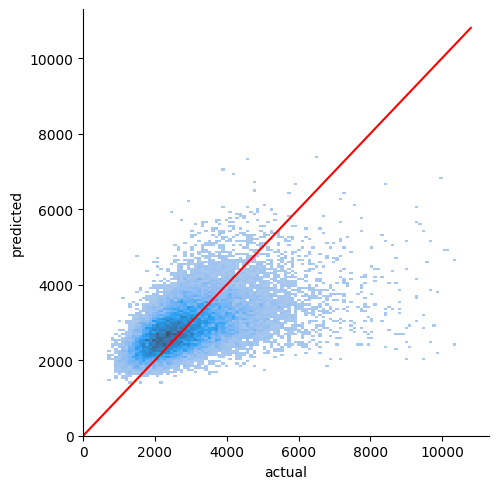

In [27]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

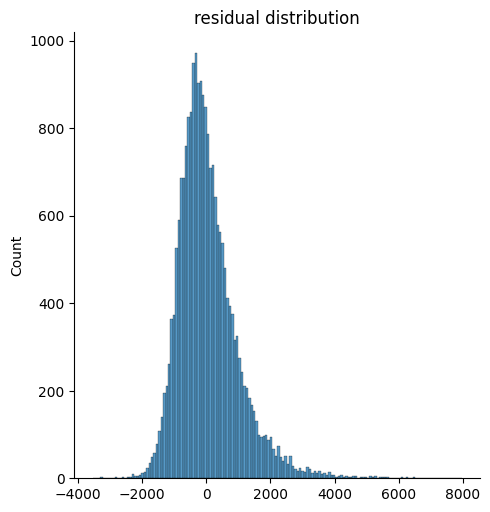

In [28]:
# Residual distribution
_ = sns.displot(df_pred["actual"] - df_pred["preds"])
_ = plt.title("residual distribution")

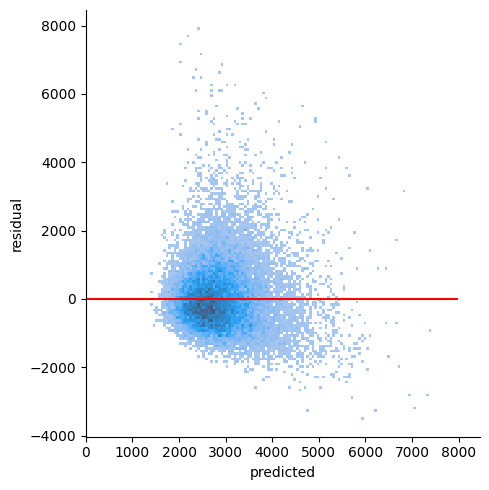

In [29]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

# Inference

In [31]:
# Get SHAP values
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

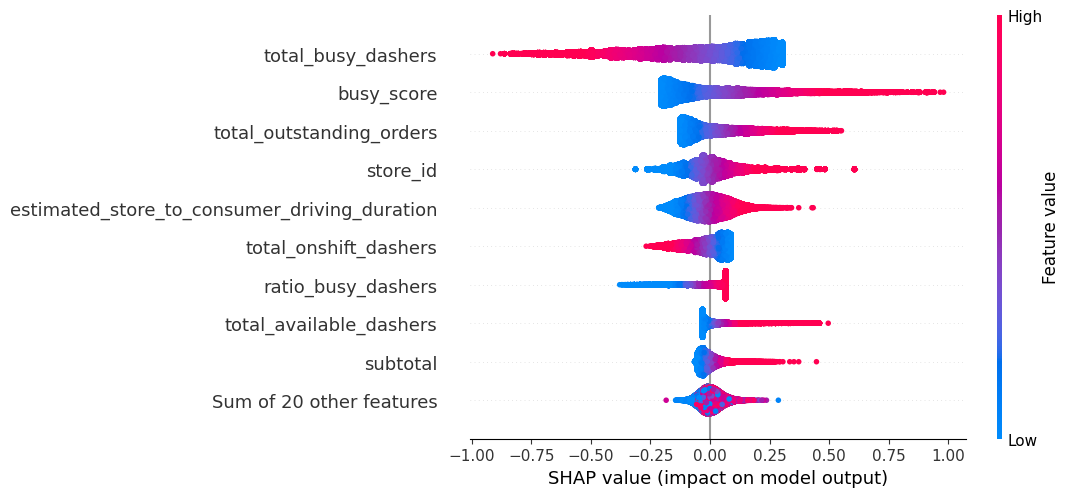

In [34]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

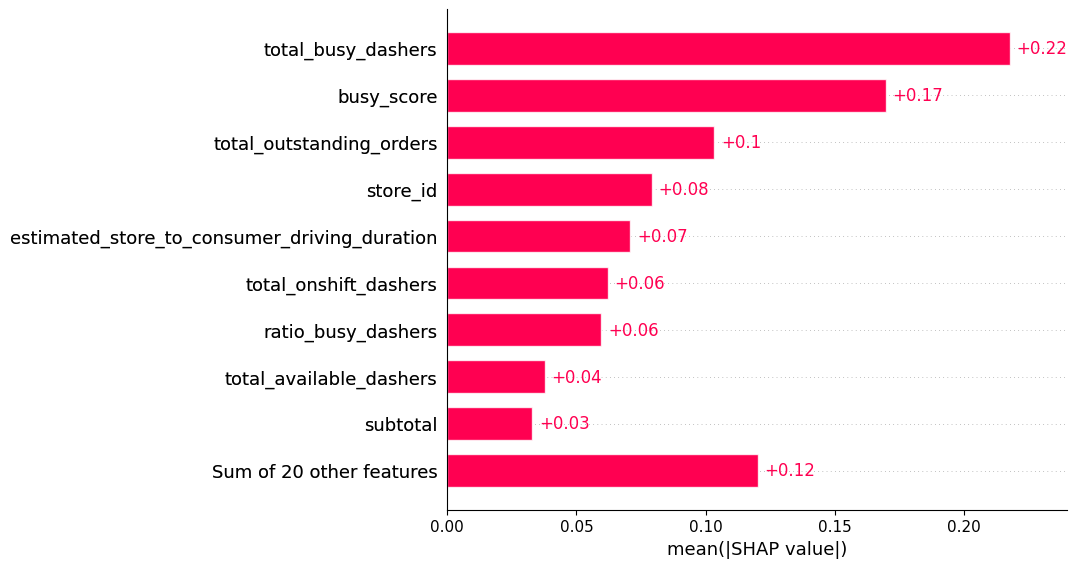

In [35]:
shap.plots.bar(shap_values)

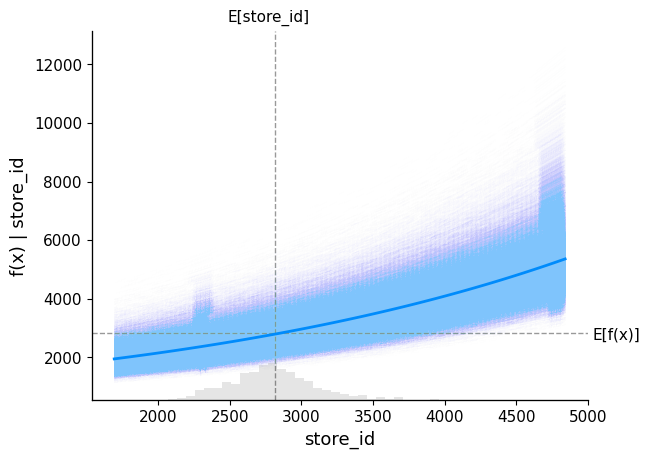

In [37]:
# Partial dependence: store_id, target encoded
shap.plots.partial_dependence(
    "store_id",
    model.predict,
    X_train,
    model_expected_value = True,
    feature_expected_value = True
)

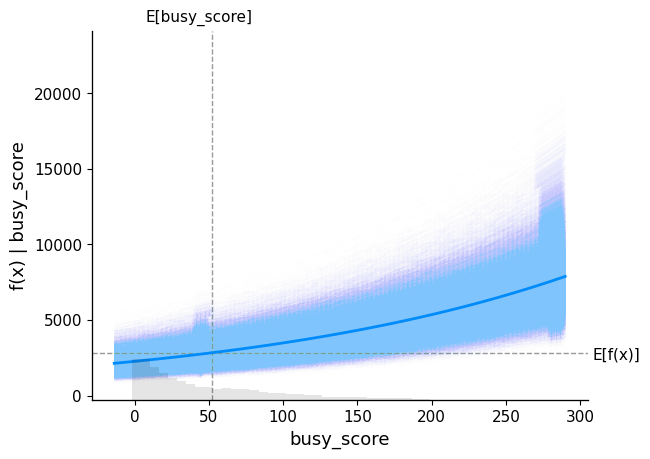

In [38]:
# Partial dependence: busy_score
shap.plots.partial_dependence(
    "busy_score",
    model.predict,
    X_train,
    model_expected_value = True,
    feature_expected_value = True
)

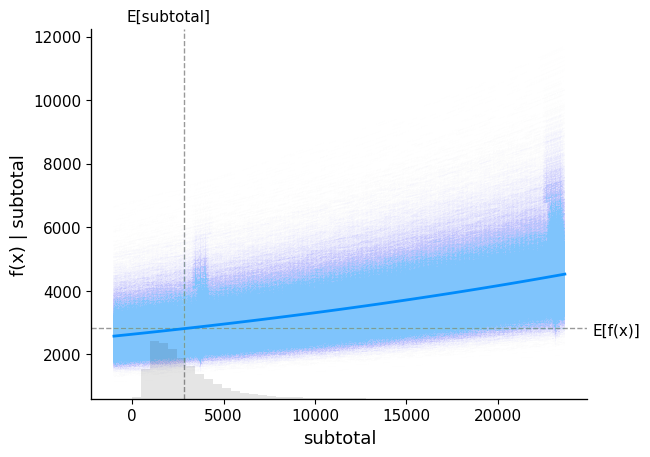

In [39]:
# Partial dependence: subtotal
shap.plots.partial_dependence(
    "subtotal",
    model.predict,
    X_train,
    model_expected_value = True,
    feature_expected_value = True
)

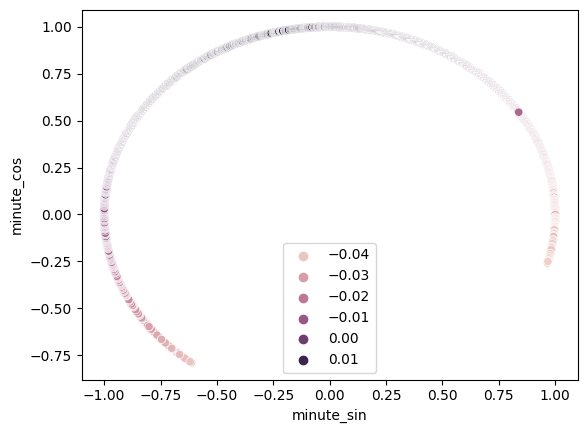

In [40]:
# EXPERIMENTAL: Plot cyclical minute feature's SHAP contributions
shap_sin = shap_values[:, "minute_sin"].values
shap_cos = shap_values[:, "minute_cos"].values
_ = sns.scatterplot(data = X_train, x = "minute_sin", y = "minute_cos", hue = (shap_sin + shap_cos))

- Bottom right: ~7AM

- Top: ~12AM

- Bottom left: ~14:30PM

# Findings
- Fairly close performance to XGBoost and LGBM, even though top features are considerably different.
- The learned relationship for cyclical minute features is different from XGB & LGBM.
- Top features according to SHAP are considerably different from XGB & LGBM.